In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

## Loading dataset

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1726,1958-RNRKS,Male,0,Yes,No,30,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,49.90,1441.95,No
6692,8591-NXRCV,Female,0,No,No,41,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),74.65,3090.65,No
2474,5630-IXDXV,Female,0,No,No,47,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.35,4849.1,No
6381,0927-CNGRH,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55,No
1150,8807-ARQET,Female,0,No,No,41,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,40.35,1677.85,No


In [6]:
df.drop(columns = ['customerID'], inplace=True)

## Checking datatypes and handling categorical variables

In [7]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Handling Object type columns**

In [8]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


In [12]:
df.replace({'Yes': 1,'No': 0, 'No internet service':0, 'No phone service':0}, inplace=True)

In [13]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

gender: ['Female' 'Male']
InternetService: ['DSL' 'Fiber optic' 0]
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


In [14]:
df.replace({'Male': 1,'Female': 0}, inplace=True)

In [15]:
df = pd.get_dummies(data=df, columns=['InternetService','Contract','PaymentMethod'])

In [17]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                                object
Churn                                        int64
InternetService_0                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic    

In [18]:
df.TotalCharges.unique

<bound method Series.unique of 0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object>

**Total Charges Column seems to be all float but has dtype object**

In [20]:
df.TotalCharges.isnull().sum()

0

In [257]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [24]:
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors='coerce')

In [25]:
df.TotalCharges.isnull().sum()

11

**Rows with non numeric value in TotalCharges changed to null using error="coerce"**

In [30]:
df.dropna(inplace=True)
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_0                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic    

In [31]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,1,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,1,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,1990.50,0,0,1,0,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,7362.90,0,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,346.45,0,0,1,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,0,0,0,0,0,0,1,74.40,306.60,1,0,0,1,1,0,0,0,0,0,1


## Scalling tenure, monthlyCharges and TotalCharges columns

In [37]:
cols = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

In [39]:
for col in df:
    print(f'{col}: {df[col].unique()}')

gender: [0 1]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**Data Visualization**

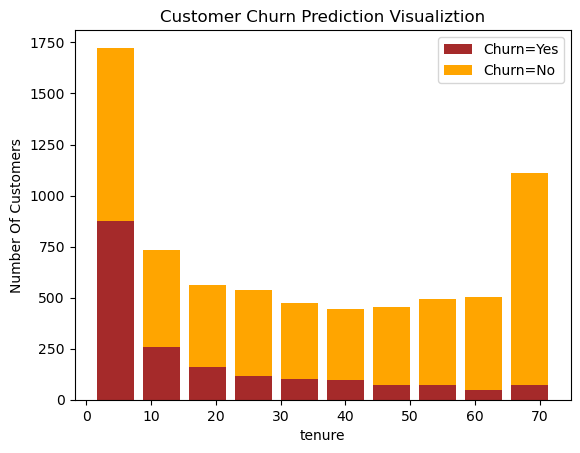

In [48]:
tenure_churn_no = df1[df1.Churn==0].tenure
tenure_churn_yes = df1[df1.Churn==1].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")


plt.hist([tenure_churn_yes, tenure_churn_no], stacked = True, rwidth=0.8, color=['brown','orange'], label=['Churn=Yes','Churn=No'])
plt.legend()

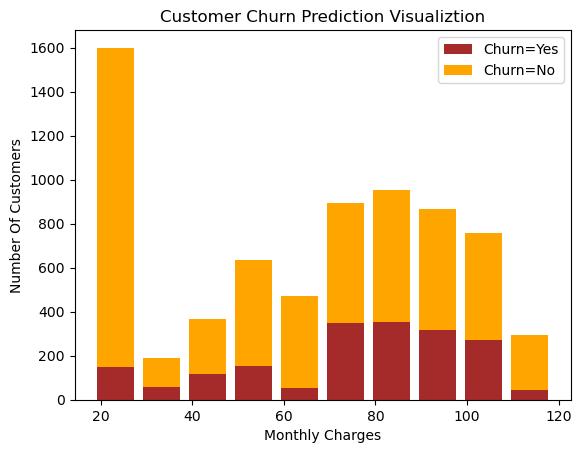

In [49]:
mc_churn_no = df1[df1.Churn==0].MonthlyCharges      
mc_churn_yes = df1[df1.Churn==1].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], stacked = True, rwidth=0.8, color=['brown','orange'], label=['Churn=Yes','Churn=No'])
plt.legend()